In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from collections import namedtuple

import checker
import utils

plt.rcParams["figure.figsize"] = (9, 5)

In [2]:
from collections import namedtuple
np.random.seed(54)

def linear_func(X):
    return -2.5 * X

def affine_func(X):
    return  -2.5 * X + 2

def square_func(X):
    return -2 * X ** 2 + 1 * X + 1

linear_dataset = utils.create_regression_dataset(linear_func)
affine_dataset = utils.create_regression_dataset(affine_func)
square_dataset = utils.create_regression_dataset(square_func)
bigger_square_dataset = utils.create_regression_dataset(square_func, sample_size=100)

Każdy z naszych datasetów zawiera atrybut .data z danymi X oraz .target z etykietami Y
linear_dataset.data: [[-0.39908516]
 [-0.68380252]
 [-1.57561656]
 [ 0.09141364]
 [-2.45697274]
 [ 2.34468103]
 [ 1.50690628]
 [ 1.28655994]
 [ 0.85742151]
 [-2.35171496]]
linear_dataset.target: [ 0.7035172   1.37442238  4.05564692 -0.36402631  6.27794289 -5.82459669
 -3.9986326  -3.38031002 -2.32424686  5.77345025]
Wszystkie datasety mają jednowymiarowe przykłady: (10, 1)


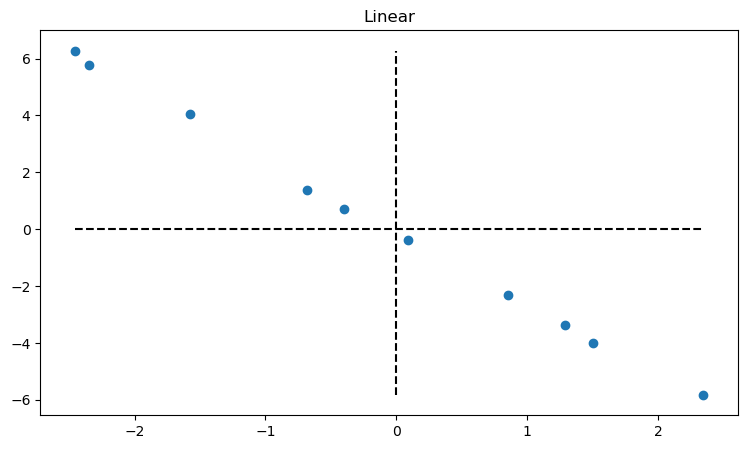

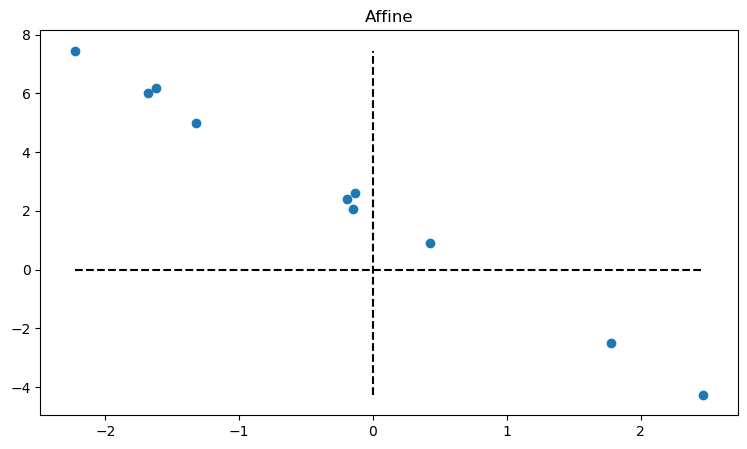

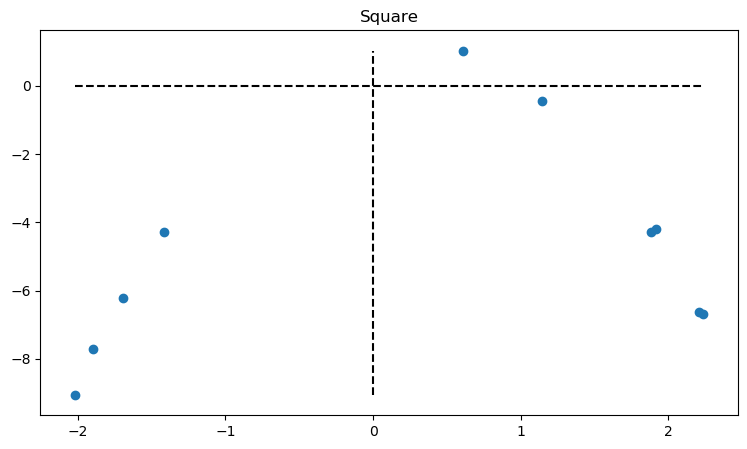

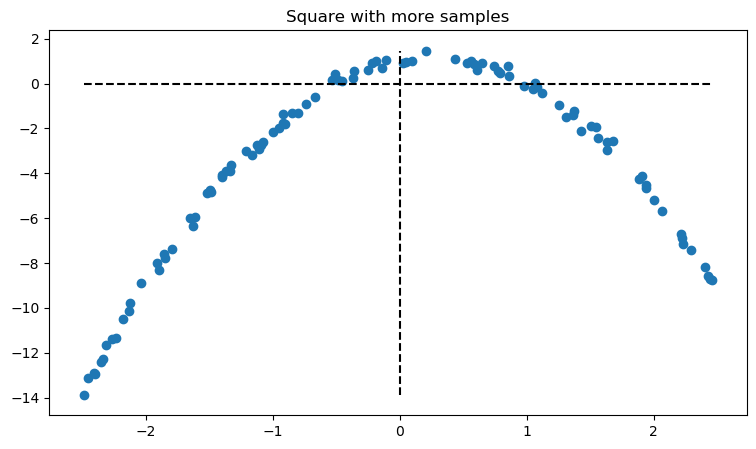

In [3]:
print("Każdy z naszych datasetów zawiera atrybut .data z danymi X oraz .target z etykietami Y")
print(f"linear_dataset.data: {linear_dataset.data}\nlinear_dataset.target: {linear_dataset.target}")
print(f"Wszystkie datasety mają jednowymiarowe przykłady: {linear_dataset.data.shape}")

utils.plot_regression_dataset(linear_dataset, "Linear")
utils.plot_regression_dataset(affine_dataset, "Affine")
utils.plot_regression_dataset(square_dataset, "Square")
utils.plot_regression_dataset(bigger_square_dataset, "Square with more samples")

In [4]:
class LinearRegression:
    def __init__(self):
        self.weight = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        XT = np.transpose(X)
        self.weight = np.linalg.inv(XT@X) @ XT @ y

    def predict(self, X: np.ndarray) -> np.ndarray:
        return X @ self.weight

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        return np.mean((LinearRegression.predict(self, X) - y)**2)
        # squared_error = np.square((X @ self.weight) - y)
        # return np.sum(squared_error)/X.shape[0]

checker.check_02_linear_regression(LinearRegression)

In [5]:
def embed_bias(X: np.ndarray):
    return np.concatenate([X, np.ones_like(X)], -1)

def embed_poly(X: np.ndarray, poly_degree=2):
    polys = [X ** degree for degree in range(poly_degree + 1)]
    return np.concatenate(polys, axis=-1)

def embed_trig(X: np.ndarray):
    trig_list = [np.ones_like(X), X, np.sin(X), np.cos(X)]
    return np.concatenate(trig_list, -1)

In [112]:
from sklearn import datasets

class RegularizedLinearRegression:
    def __init__(self, lr=1e-6, alpha=1e-2):
        self.learning_rate = lr
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray, n_steps=int(5e4)) -> None:
        self.weight = np.random.normal(size=X.shape[1])  # Initializing the weights
        w = self.weight
        for step_idx in range(n_steps):
            N = X.shape[0]
            grad = 2*self.alpha*w + 2*(X.T@(X@w-y))/N
            w = w - grad*self.learning_rate
        self.weight = w

    def predict(self, X: np.ndarray):
        return np.dot(X,self.weight)

    def loss(self, X: np.ndarray, y: np.ndarray):
        w = self.weight
        ret = np.mean((X @ w - y) ** 2)
        ret += self.alpha * (np.linalg.norm(w) ** 2)
        return ret

checker.check_02_regularized_linear_regression(RegularizedLinearRegression)

In [ ]:
def cubic_func(X):
    return X ** 3 - 2 * X

X_linspace = np.linspace(-2.5, 2.5)
plt.plot(X_linspace, cubic_func(X_linspace))
plt.title("New data-generating function")
plt.show()

dataset = utils.create_regression_dataset(cubic_func, 500, embed_poly, {"poly_degree": 5})

In [103]:
import math

def split_data(data_x: np.ndarray, data_y: np.ndarray):
    assert len(data_x) == len(data_y)
    length = len(data_x)
    p = np.random.permutation(length)
    data_x = data_x[p]
    data_y = data_y[p]
    train_set = (
        np.take(data_x, range(math.floor(0.6*length)), axis=0),
        np.take(data_y, range(math.floor(0.6*length)), axis=0)
    )
    valid_set = (
        np.take(data_x, range(math.floor(0.6*length), math.floor(0.8*length)), axis=0),
        np.take(data_y, range(math.floor(0.6*length), math.floor(0.8*length)), axis=0)
    )
    test_set = (
        np.take(data_x, range(math.floor(0.8*length), length), axis=0),
        np.take(data_y, range(math.floor(0.8*length), length), axis=0)
    )
    return train_set, valid_set, test_set

train_set, valid_set, test_set = split_data(dataset.data, dataset.target)

In [122]:
reg_lin_regression = RegularizedLinearRegression()
params = np.random.random_sample(size=(10,3))/1000

# why with params 100 times larger the value of loss function tends to infinity when increasing number of steps in fit function?
# in such a case even with 100 steps the result of loss function is NaN
for i in range(10):
    reg_lin_regression.alpha = params[i][0]
    reg_lin_regression.learning_rate = params[i][1]
    reg_lin_regression.fit(train_set[0], train_set[1])
    params[i][2] = reg_lin_regression.loss(valid_set[0], valid_set[1]) # saving loss value

min_loss = params[0]
for i in range(1,10):
    if min_loss[2] > params[i][2]:
        min_loss = params[i]

reg_lin_regression.alpha = min_loss[0]
reg_lin_regression.learning_rate = min_loss[1]
print(f"Best results:\n"
      f"alpha = {min_loss[0]}\n"
      f"learning_rate = {min_loss[1]}\n"
      f"loss = {reg_lin_regression.loss(test_set[0], test_set[1])}")

Best results:
alpha = 0.00011077894602911586
learning_rate = 0.00042768268135300047
loss = 0.051600421926891085
